<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/5_CodingDrillDown/MNIST_BestModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Target:

- Add some capacity (additional FC layer after GAP) to the model and added LR Scheduler

## Results:
- Parameters: 6720
- Best Training Accuracy: 99.43
- Best Test Accuracy: 99.53

## Analysis:

- The model parameters have increased
- The model is under-fitting. This is fine, as we know we have made our train data harder.
- LR Scheduler and the additional capacity after GAP helped getting to the desired target 99.4, Onecyclic LR is being used, this seemed to perform better than StepLR to achieve consistent accuracy in last few layers

In [5]:
from google.colab import drive
drive.mount('/content/drive')
# Insert the directory
import sys
sys.path.insert(0,'/content/drive/MyDrive/ERAv1/5_CodingDrillDown')

from model import Net

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR,OneCycleLR



## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [8]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 191649662.78it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21386951.59it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 81350029.37it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20752209.99it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=1, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Add batch normalization, no matter how complex is the data batch normalization can handle that. Batch norm fixes the problems with high contrast and low contract issues with the images.

Batch normaliztion maintains and stores a specific mean and std deviation for each layer, because it has to normlize it and untilmately it has to learn how to normalize the particular layer evntually even during the inference,  so there is a increase in the number of parameters after batch norm

In [ ]:
#JUST FOR REFERENCE MOVED THE MODEL TO MODEL.PY
'''dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),  # Input 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # Input 26x26 output 24x24 RF : 5x5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        )

        #Transition Block
        self.trans1 = nn.Sequential(

            nn.MaxPool2d(2, 2), #  Input 24x24 output 12x12 RF : 6x6
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)  # Input 12x12 output 12x12 RF : 6x6
        )


        # CONVOLUTION BLOCK 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),  # Input 12x12 output 10x10 RF : 6x6
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  # Input 10x10 output 8x8 RF : 10x10
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=16, out_channels=18, kernel_size=(3, 3), padding=0, bias=False), # Input 8x8 output 6x6 RF : 14x14
            nn.ReLU(),
            nn.BatchNorm2d(18),
            nn.Dropout(dropout_value)

        )

        # OUTPUT BLOCK
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), # Input 6x6 output 6x6 RF : 18x18
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value))

        self.conv4 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)  # Input 6x6 output 6x6 RF : 18x18


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.avgpool2d(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 10, 10, 10]             720
             ReLU-12           [-1, 10, 10, 10]               0

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [12]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.7)

scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=15,steps_per_epoch=len(train_loader))


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)



EPOCH: 1


Loss=0.3688625991344452 Batch_id=468 Accuracy=66.73: 100%|██████████| 469/469 [00:56<00:00,  8.30it/s]



Test set: Average loss: 0.1607, Accuracy: 9659/10000 (96.59%)

EPOCH: 2


Loss=0.12022694945335388 Batch_id=468 Accuracy=94.10: 100%|██████████| 469/469 [00:53<00:00,  8.71it/s]



Test set: Average loss: 0.0498, Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.10425104945898056 Batch_id=468 Accuracy=96.22: 100%|██████████| 469/469 [00:54<00:00,  8.65it/s]



Test set: Average loss: 0.0430, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.16860465705394745 Batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:52<00:00,  8.94it/s]



Test set: Average loss: 0.0370, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.1413065791130066 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:52<00:00,  8.92it/s]



Test set: Average loss: 0.0370, Accuracy: 9892/10000 (98.92%)

EPOCH: 6


Loss=0.03711237385869026 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:55<00:00,  8.41it/s]



Test set: Average loss: 0.0298, Accuracy: 9904/10000 (99.04%)

EPOCH: 7


Loss=0.029260382056236267 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:53<00:00,  8.74it/s]



Test set: Average loss: 0.0406, Accuracy: 9885/10000 (98.85%)

EPOCH: 8


Loss=0.05077042803168297 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:52<00:00,  8.94it/s]



Test set: Average loss: 0.0231, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.04084783419966698 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:53<00:00,  8.75it/s]



Test set: Average loss: 0.0233, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.022027485072612762 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:52<00:00,  9.00it/s]



Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.08090413361787796 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:51<00:00,  9.03it/s]



Test set: Average loss: 0.0212, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.013735600747168064 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:51<00:00,  9.06it/s]



Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.04734157398343086 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:51<00:00,  9.03it/s]



Test set: Average loss: 0.0194, Accuracy: 9947/10000 (99.47%)

EPOCH: 14


Loss=0.0075936452485620975 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:52<00:00,  8.90it/s]



Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Loss=0.03242568299174309 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:53<00:00,  8.85it/s]



Test set: Average loss: 0.0173, Accuracy: 9953/10000 (99.53%)



Text(0.5, 1.0, 'Test Accuracy')

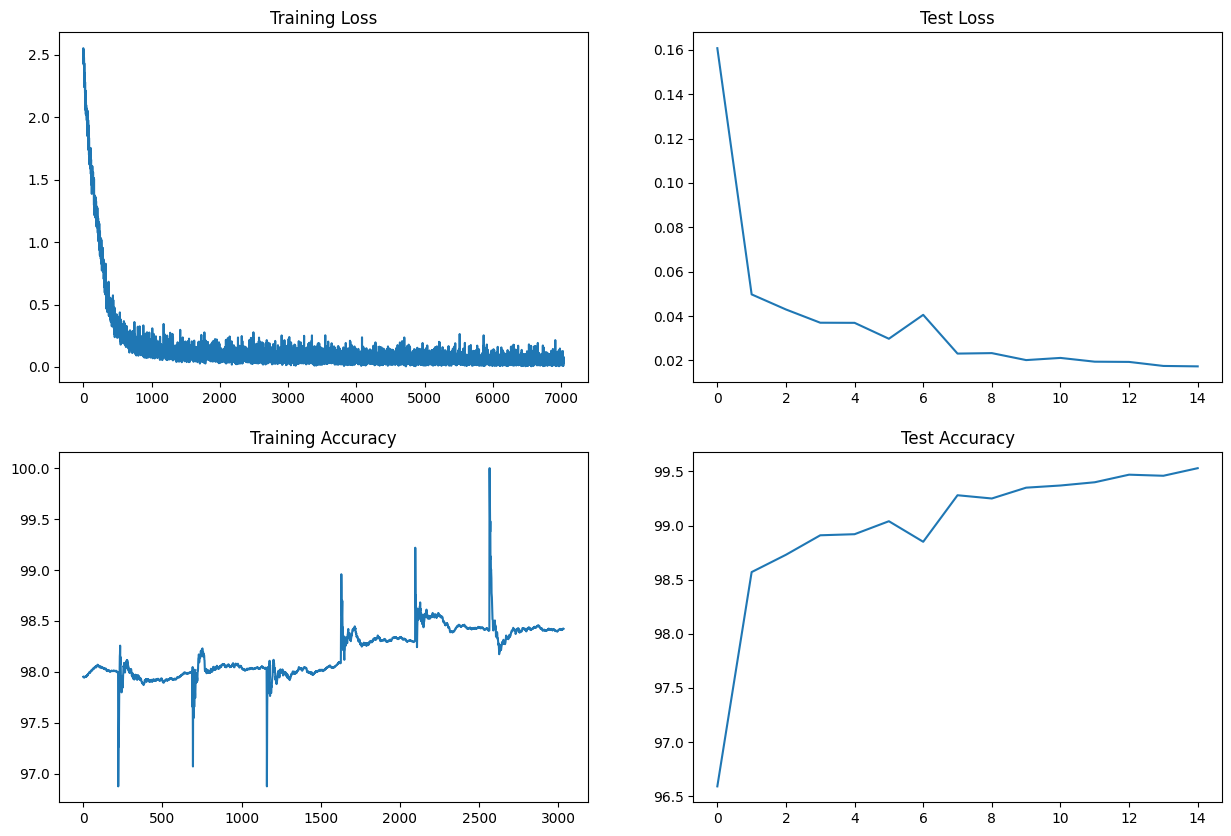

In [16]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Incorrect Predictions

In [17]:
def print_wrong_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])

  return list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))

In [19]:
wrong_predictions = print_wrong_predictions(test_loader,model,device)

In [20]:
print(f'Total wrong predictions are {len(wrong_predictions)}')

Total wrong predictions are 47


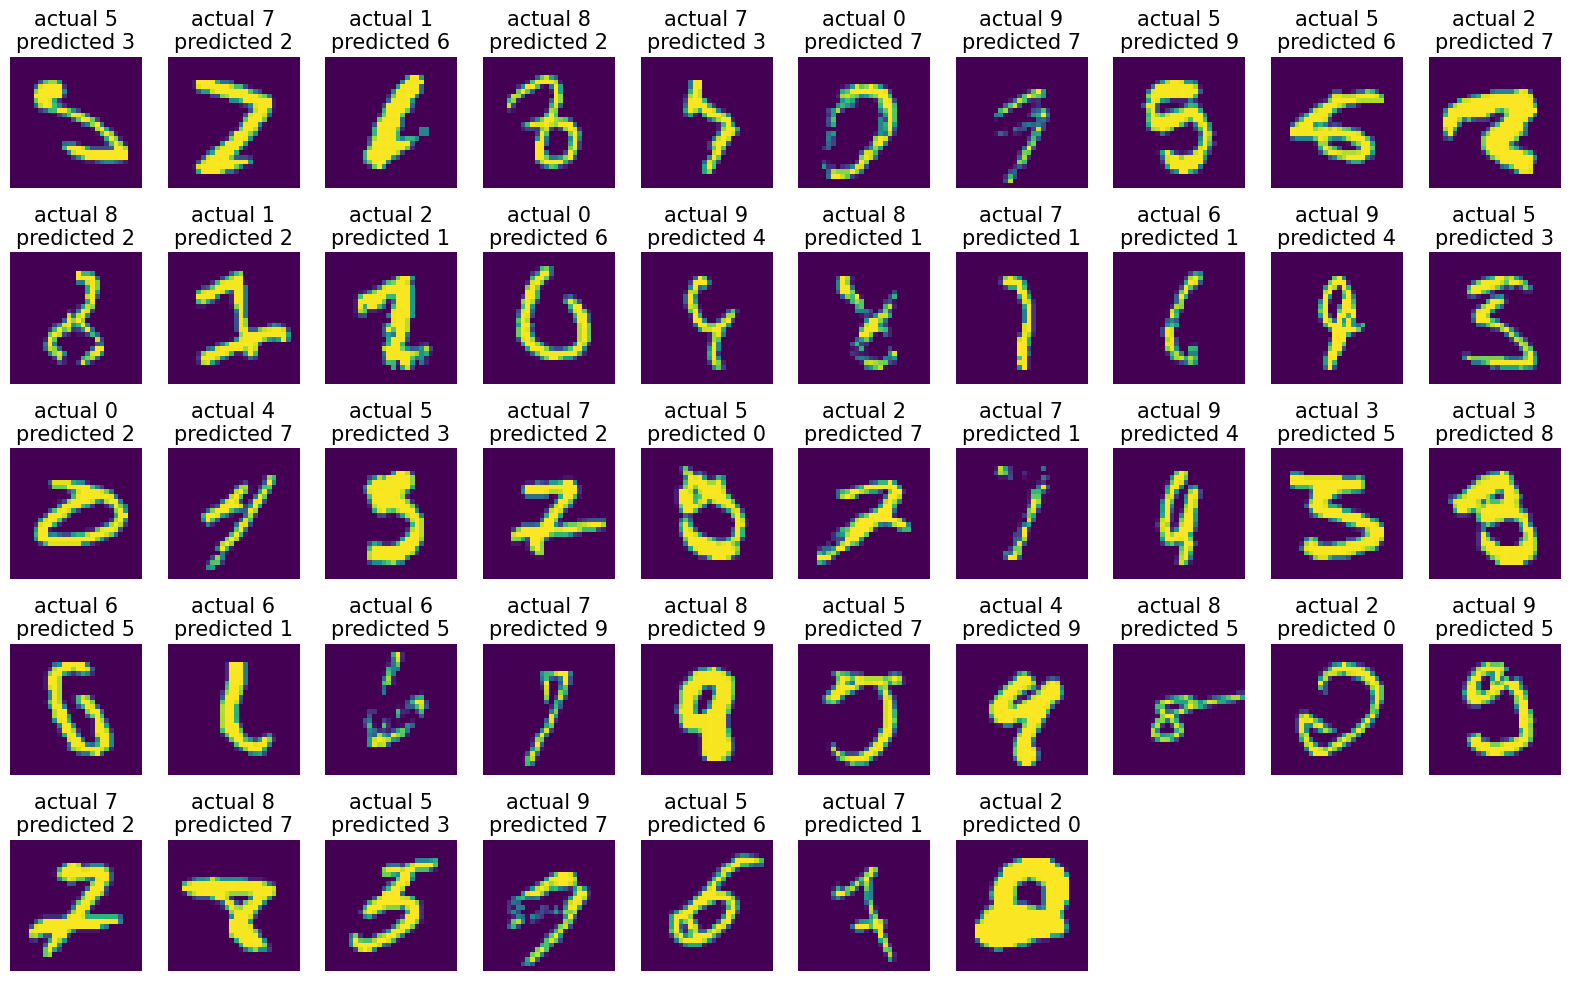

In [21]:
fig = plt.figure(figsize=(20,25))
for i, (img, pred, correct) in enumerate(wrong_predictions[:50]):
    img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
    ax = fig.add_subplot(10, 10, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())
plt.show()